#### Description - Create Figures regarding the Spectrogram Analyses

The primary outputs of this notebook include:

* Figure 3: Representative subject and description of the spectrogram analyses

# Import Libraries

In [1]:
import os
import pandas as pd
import numpy  as np
import os.path as osp
from utils.variables import DATA_DIR, Resources_Dir
from utils.basics import get_available_runs

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import hvplot.pandas
import panel as pn

from scipy.stats import ttest_ind

%matplotlib inline

In [2]:
def get_available_runs(when='post_download', type='all'):
    """
    This function returns a list with all run names available at different times during the 
    analyses according to the when parameter.
    
    Inputs
    ------
    when: str with three possible values: post_download, post_qa1, final
    type: str with three possible values: all, drowsy, awake. This only applies if when = final
    
    Outputs
    -------
    out_list: list of strings with run names.
    """
    out_list = []
    # List of runs for which fMRI data was acquired
    if when == 'post_download':
        data = pd.read_pickle(ProjectFiles_DF_Path)
    # List of runs for which ET exists
    if when == 'post_qa1':
        data = pd.read_pickle(QA1_Results_DF_Path)
        data = data[(data['ET_OK']==True) & (data['ET Avail']==True) & (data['Spatial Resolution OK']==True) & (data['TR OK']==True) & (data['Nacq OK']==True)]
        for index,row in data.iterrows():
            sbj = str(row['Sbj'])
            run = str(row['Run'])
            out_list.append('_'.join([sbj,run]))
    if when == 'final':
        path_awake  = osp.join(Resources_Dir,'Run_List_Awake.Sukru.txt')
        path_drowsy = osp.join(Resources_Dir,'Run_List_Drowsy.Sukru.txt')
        awake_list  = list(np.loadtxt(path_awake,dtype=str))
        drowsy_list = list(np.loadtxt(path_drowsy,dtype=str))
        if type == 'all':
            out_list    = awake_list + drowsy_list
        elif type == 'awake':
            out_list = awake_list
        elif type == 'drowsy':
            out_list = drowsy_list
    return out_list

def load_segments(kind,runs=None,min_dur=None):
    """
    Load information about scan segments according to ET data
    
    INPUTS
    runs: list of scans ID to include
    kind: type of target segments (EC=eyes closed, EO=eyes open)
    min_dur: remove any segment with duration less than this threshold (in seconds)
    
    OUTPUTS
    df: dataframe with one row per segment of interest. For each segment it will include the runID,
        segment type, segment index, segment UUID, segment onset (secodns), segment offset (seconds), 
        segment duration (seconds) and scan label.
    """
    if kind == 'all':
       path_EC = osp.join(Resources_Dir,'EC_Segments_Info.Sukru.pkl')
       path_EO = osp.join(Resources_Dir,'EO_Segments_Info.Sukru.pkl')
       df_EC   = pd.read_pickle(path_EC)
       df_EO   = pd.read_pickle(path_EO)
       df      = pd.concat([df_EO, df_EC], axis=0).reset_index(drop=True)
    else:
       path = osp.join(Resources_Dir,'{k}_Segments_Info.Sukru.pkl'.format(k=kind))
       df   = pd.read_pickle(path)
    
    if min_dur is not None:
        df=df[df['Duration']>min_dur] # JAVIER: may want to change to >=min_dur lateer #
      
    if runs is not None:
       df=df[df['Run'].isin(runs)]
    
    print('++ INFO: segment_df has shape: %s' % str(df.shape))
    
    return df

In [3]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid",{"xtick.major.size": 0.1,
    "xtick.minor.size": 0.05,'grid.linestyle': '--'})

# Analysis Configuration Variables

In [4]:
region             = 'V4lt_grp' # Use the Group-Level FV ROI
gs_region          = 'GM'       # Region used to define the global signal (options='GM','FB')
gs_step            = 'mPP'      # Options: 'mPP','Reference','Basic','Basicpp','Behzadi_COMPCOR','Behzadi_COMPCORpp' | Manuscript: 'mPP'
remove_HRa_scans  = False      # If true, do analyses after removing scans with overlapping alisaed HR in the sleep band
spectrogram_windur = 60         # Spectrogram Window Duration (In seconds)
Nacq               = 890        # Number of acquisitions

# Generate Time Index for Windowed Results

Having these two indexes will help us plot original data and windowed frequency information in a way that aligns visually and helps with interpretation

In [5]:
# First we generate a regular time index (the one that corresponds to the fMRI TR)
time_index         = pd.timedelta_range(start='0 s', periods=Nacq, freq='s')
print('++ Time Index (first 10 values):')
print(time_index[0:10])

++ Time Index (first 10 values):
TimedeltaIndex(['0 days 00:00:00', '0 days 00:00:01', '0 days 00:00:02',
                '0 days 00:00:03', '0 days 00:00:04', '0 days 00:00:05',
                '0 days 00:00:06', '0 days 00:00:07', '0 days 00:00:08',
                '0 days 00:00:09'],
               dtype='timedelta64[ns]', freq='S')


In [6]:
# Create empty dataframe with index having time_delta in steps of seconds
aux = pd.DataFrame(np.ones(Nacq),index=time_index)
# Simulate rolling windows of spectrogram_windur to gather which index should have data
aux                    = aux.rolling(window=spectrogram_windur, center=True).mean()
aux                    = aux.dropna()
windowed_time_index    = aux.index
print('++ Window Index (first 10 values):')
print(windowed_time_index[0:10])

++ Window Index (first 10 values):
TimedeltaIndex(['0 days 00:00:30', '0 days 00:00:31', '0 days 00:00:32',
                '0 days 00:00:33', '0 days 00:00:34', '0 days 00:00:35',
                '0 days 00:00:36', '0 days 00:00:37', '0 days 00:00:38',
                '0 days 00:00:39'],
               dtype='timedelta64[ns]', freq='S')


***
# Figure: Evolution of PSD across scan types

### Load list of runs classified as awake and drowsy

In [7]:
%%time
if remove_HRa_scans:
    scenario        = 'noHRa'
    scan_HR_info    = pd.read_csv(osp.join(Resources_Dir,'HR_scaninfo.Sukru.csv'), index_col=0)
    scan_HR_info    = scan_HR_info[(scan_HR_info['HR_aliased']< 0.03) | (scan_HR_info['HR_aliased']> 0.07)]
    Manuscript_Runs = list(scan_HR_info.index)
    Awake_Runs      = list(scan_HR_info[scan_HR_info['Scan Type']=='Awake'].index)
    Drowsy_Runs     = list(scan_HR_info[scan_HR_info['Scan Type']=='Drowsy'].index)
else:
    scenario        = 'all'
    Manuscript_Runs = get_available_runs(when='final', type='all')
    Awake_Runs      = get_available_runs(when='final', type='awake')
    Drowsy_Runs     = get_available_runs(when='final', type='drowsy')
    
print('++ INFO: Number of Runs: Total = %d | Awake = %d | Drowsy = %d' % (len(Manuscript_Runs), len(Awake_Runs), len(Drowsy_Runs)))

++ INFO: Number of Runs: Total = 425 | Awake = 271 | Drowsy = 154
CPU times: user 5.74 ms, sys: 1.72 ms, total: 7.45 ms
Wall time: 6.36 ms


***
### Load PSD in Sleep Band

This data is already the result of a windowing operation (computation of the spectrogram). As such, we ensure the index has the correct values corresponding to windowed information

In [8]:
%%time
sleep_psd_DF = pd.DataFrame(index=windowed_time_index, columns=Manuscript_Runs)
ctrol_psd_DF = pd.DataFrame(index=windowed_time_index, columns=Manuscript_Runs)

for sbj_run in Manuscript_Runs:
    sbj,run = sbj_run.split('_',1)
    file    = '{RUN}_mPP.Signal.{REGION}.Spectrogram_BandLimited.pkl'.format(RUN=run, REGION=region)
    path    = osp.join(DATA_DIR,sbj,run,file)
    aux     = pd.read_pickle(path)
    sleep_psd_DF.loc[(windowed_time_index,sbj_run)] = aux['sleep'].values
    ctrol_psd_DF.loc[(windowed_time_index,sbj_run)] = aux['control'].values

sleep_psd_cumsum_DF = sleep_psd_DF.cumsum()
ctrol_psd_cumsum_DF = ctrol_psd_DF.cumsum()

print('++ INFO: Shape of PSD Dataframe [sleep_psd_DF] is %s' % str(sleep_psd_DF.shape))

++ INFO: Shape of PSD Dataframe [sleep_psd_DF] is (831, 425)
CPU times: user 711 ms, sys: 126 ms, total: 838 ms
Wall time: 7.39 s


***
# Prepare PSD Dataframes for plotting with Seaborn & Compute Cumulative Version of PSD Estimates

In [9]:
# Putting average PSD data into tidy-form with axis in terms of seconds (not delta time)
sleep_psd_DF_copy               = sleep_psd_DF.copy()
sleep_psd_DF_copy.index         = sleep_psd_DF_copy.index.total_seconds()
sleep_psd_cumsum_DF_copy        = sleep_psd_cumsum_DF.copy()
sleep_psd_cumsum_DF_copy.index  = sleep_psd_cumsum_DF_copy.index.total_seconds()
sleep_psd_stacked_DF            = pd.DataFrame(sleep_psd_DF_copy.stack()).reset_index()
sleep_psd_cumsum_stacked_DF     = pd.DataFrame(sleep_psd_cumsum_DF_copy.stack()).reset_index()
# Putting average PSD data into tidy-form with axis in terms of seconds (not delta time)
ctrol_psd_DF_copy               = ctrol_psd_DF.copy()
ctrol_psd_DF_copy.index         = ctrol_psd_DF_copy.index.total_seconds()
ctrol_psd_cumsum_DF_copy        = ctrol_psd_cumsum_DF.copy()
ctrol_psd_cumsum_DF_copy.index  = ctrol_psd_cumsum_DF_copy.index.total_seconds()
ctrol_psd_stacked_DF            = pd.DataFrame(ctrol_psd_DF_copy.stack()).reset_index()
ctrol_psd_cumsum_stacked_DF     = pd.DataFrame(ctrol_psd_cumsum_DF_copy.stack()).reset_index()
# Delete temporary Objects
del sleep_psd_DF_copy, sleep_psd_cumsum_DF_copy, ctrol_psd_DF_copy, ctrol_psd_cumsum_DF_copy

In [10]:
# Rename columns in tidy form dataframes and add extra column with run classification (Drowsy or Awake)
for df in [sleep_psd_stacked_DF, sleep_psd_cumsum_stacked_DF,
           ctrol_psd_stacked_DF, ctrol_psd_cumsum_stacked_DF]:
    df.columns = ['Time [seconds]','Subject','PSD']
    df['Scan Type'] = 'N/A'
    df.loc[(df['Subject'].isin(Awake_Runs),'Scan Type')] = 'Awake'
    df.loc[(df['Subject'].isin(Drowsy_Runs),'Scan Type')] = 'Drowsy'
sleep_psd_stacked_DF['Frequency Band']        = 'Sleep (0.03 - 0.07 Hz)'
sleep_psd_cumsum_stacked_DF['Frequency Band'] = 'Sleep (0.03 - 0.07 Hz)'
ctrol_psd_stacked_DF['Frequency Band']        = 'Control (0.1 - 0.2 Hz)'
ctrol_psd_cumsum_stacked_DF['Frequency Band'] = 'Control (0.1 - 0.2 Hz)'

## Save into a single Dataframe Object for Plotting

In [11]:
df_cum_plot = pd.concat([sleep_psd_cumsum_stacked_DF,ctrol_psd_cumsum_stacked_DF])
df_plot = pd.concat([sleep_psd_stacked_DF,ctrol_psd_stacked_DF])

## Plot the data

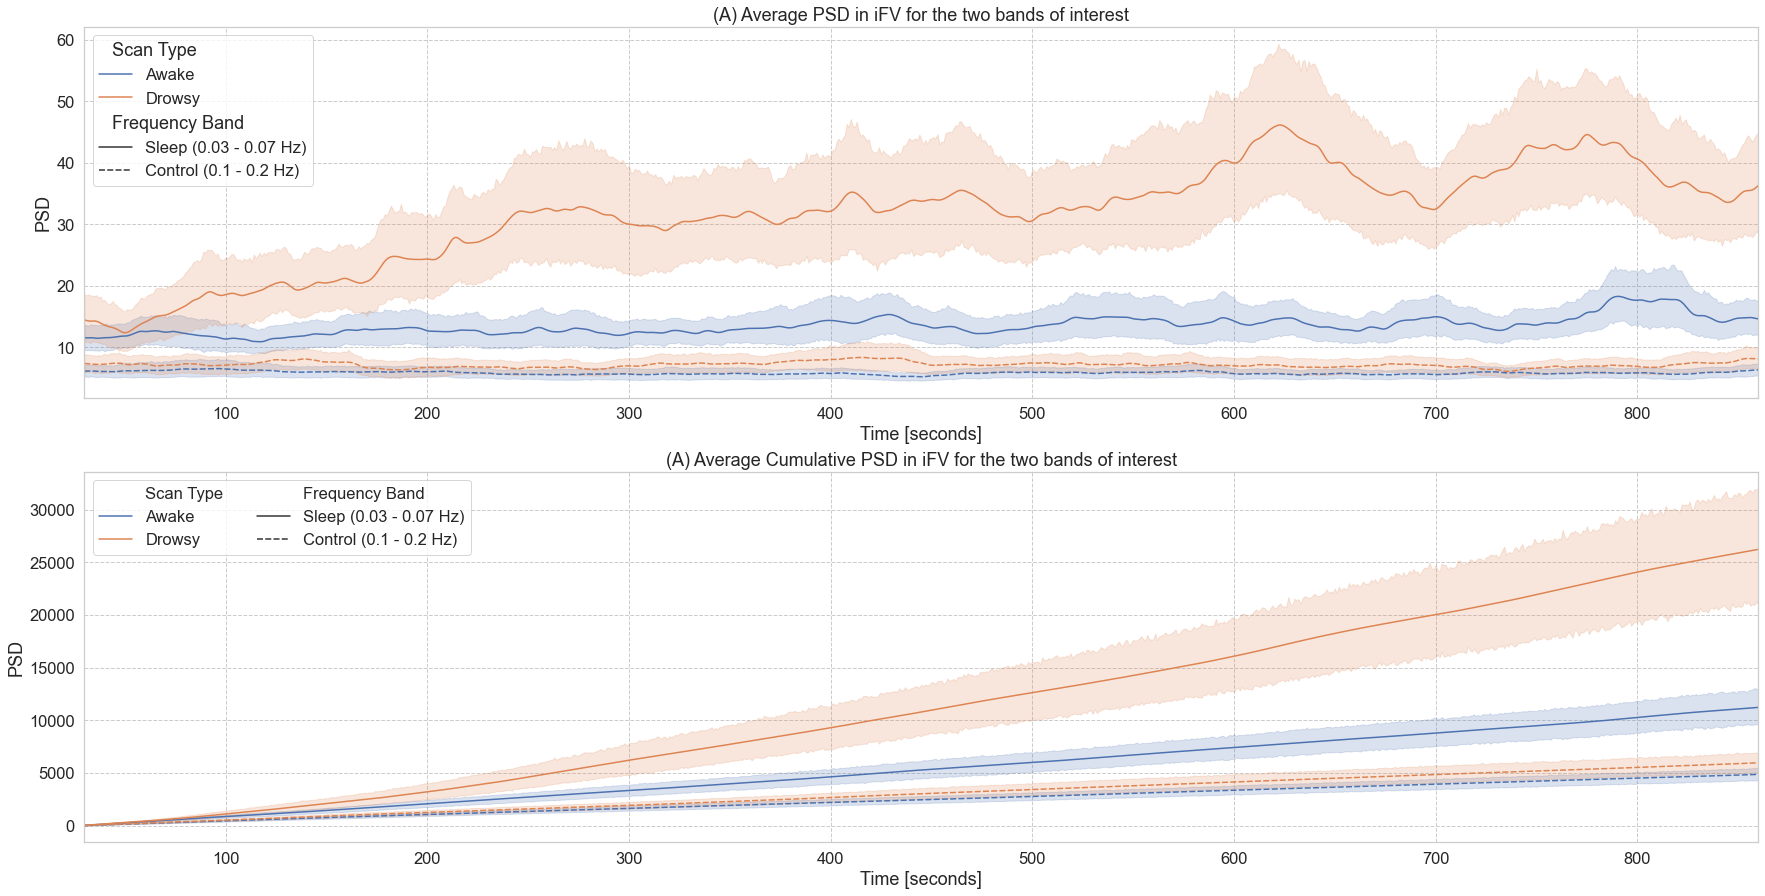

In [12]:
fig, ax = plt.subplots(2,1,figsize=(30,15))
sns.lineplot(data=df_plot, x='Time [seconds]', hue='Scan Type', y='PSD', style='Frequency Band', style_order=['Sleep (0.03 - 0.07 Hz)','Control (0.1 - 0.2 Hz)'], estimator=np.mean, n_boot=1000, ax=ax[0])
ax[0].set_xlim(df_plot['Time [seconds]'].min(),df_plot['Time [seconds]'].max())
ax[0].set_title('(A) Average PSD in iFV for the two bands of interest')
sns.lineplot(data=df_cum_plot, x='Time [seconds]', hue='Scan Type', y='PSD', style='Frequency Band', style_order=['Sleep (0.03 - 0.07 Hz)','Control (0.1 - 0.2 Hz)'], estimator=np.mean, n_boot=1000, ax=ax[1])
ax[1].set_title('(A) Average Cumulative PSD in iFV for the two bands of interest')
ax[1].set_xlim(df_cum_plot['Time [seconds]'].min(),df_cum_plot['Time [seconds]'].max())
ax[1].legend(ncol=2)

> **<u>FINDING:</u>**: As scanning progresses, we see a differentiation in terms of instaneous PSD between subjects who kept their eyes open continously and those who did not. The second group tends to have a higher PSD at longer scanning times. Now becuase periods of eye closure do not necessarily align across subjects, the strength observed here is somehow weak.

> **<u>FINDING:</u>**: As scanning progresses, we see a differentiation in terms of cumulative PSD between subjects who kept their eyes open continously and those who did not. The second group tends to have a higher cumulative PSD at longer scanning times. By looking at cumulative PSD we overcome the limitation mentioned above, and the differentiation across groups becomes more evident

In [13]:
fig.savefig('./figures/Revision1_Figure07.{region}.{scenario}.Sukru.png'.format(region=region,scenario=scenario))